# MLNS ASSIGNEMENT - MISSING LINK PREDICTION

## I - INITIALISING ENVIRONMENT

In [2]:
import numpy as np
import csv
import pandas as pd
pd.set_option('display.max_columns', None)
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx.algorithms.community as community

Nombre de nœuds : 3597
Nombre de liens : 10496
Degré moyen : 5.835974423130386


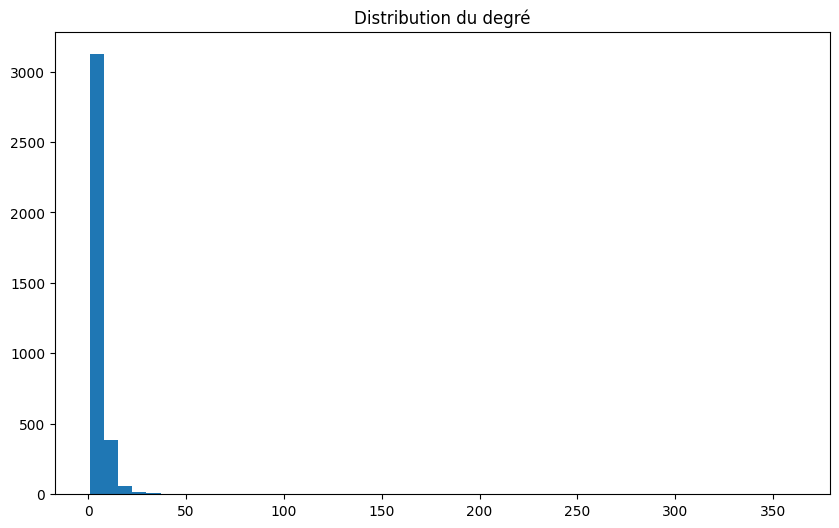

Les 5 nœuds avec la plus grande centralité : [(3809, 0.10038932146829811), (6416, 0.014738598442714126), (7426, 0.01167964404894327), (7174, 0.010845383759733037), (7272, 0.010845383759733037)]
Densité du réseau : 0.001622907236688094


In [3]:

# 2. Charger les données
node_info = pd.read_csv("../data/node_information.csv", header=None)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])


# Créer un graphe à partir du train_set
G = nx.from_pandas_edgelist(train_set, 'source', 'target', 'label')

# Nombre de nœuds
print("Nombre de nœuds :", G.number_of_nodes())

# Nombre de liens
print("Nombre de liens :", G.number_of_edges())

# Degré moyen
## Dans un réseau, le degré d'un nœud est le nombre de liens qu'il a avec d'autres nœuds.
degrees = [G.degree(n) for n in G.nodes()]
print("Degré moyen :", np.mean(degrees))

# Distribution du degré
plt.figure(figsize=(10,6))
plt.title("Distribution du degré")
plt.hist(degrees, bins=50)
plt.show()

# Centralité
## La centralité d'un nœud mesure son importance relative au sein du réseau. 
##Il existe plusieurs mesures de centralité, dont la centralité de degré (nombre de liens vers un nœud), 
##la centralité de proximité (inverse de la somme des distances à tous les autres nœuds), et 
##la centralité d'intermédiarité (nombre de fois qu'un nœud agit comme un pont le long du chemin le plus court entre deux autres nœuds).
centrality = nx.degree_centrality(G)
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
print("Les 5 nœuds avec la plus grande centralité :", sorted_centrality[:5])

# Densité du réseau
## La densité d'un réseau est le rapport entre le nombre de liens réels dans le réseau et le nombre de liens possibles.
print("Densité du réseau :", nx.density(G))

# Feature Engineering

In [4]:
# Importer les bibliothèques nécessaires
import networkx as nx
import networkx.algorithms.community as nx_community

def salton_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / ((degree_u * degree_v) ** 0.5)

def sorenson_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, 2 * common_neighbors / (degree_u + degree_v)


def hub_promoted_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / min(degree_u, degree_v)

def hub_depressed_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / max(degree_u, degree_v)

def adamic_adar_index(G, edges):
    for u, v in edges:
        score = 0
        for w in nx.common_neighbors(G, u, v):
            degree_w = G.degree(w)
            if degree_w > 1:
                score += 1 / np.log(degree_w)
        yield u, v, score

# Creer une fonction qui ajoute des features (degree, centrality, clustering) à un graphes et qui merge node_info avec le graphe
def add_node_attributes(df, node_info):
     # Créer un graphe à partir du df
     if 'label' in df.columns:
        G = nx.from_pandas_edgelist(df, 'source', 'target', 'label')
     else:
        G = nx.from_pandas_edgelist(df, 'source', 'target')

     # Calculer les caractéristiques
     df['degree_source'] = df['source'].apply(lambda x: G.degree(x))
     df['centrality_source'] = df['source'].apply(lambda x: nx.degree_centrality(G)[x])
     #df['clustering_source'] = df['source'].apply(lambda x: nx.clustering(G)[x])

     df['degree_target'] = df['target'].apply(lambda x: G.degree(x))
     df['centrality_target'] = df['target'].apply(lambda x: nx.degree_centrality(G)[x])
     #df['clustering_target'] = df['target'].apply(lambda x: nx.clustering(G)[x])

     # Détecter les communautés et créer une caractéristique de communauté
     communities = nx_community.greedy_modularity_communities(G)
     community_map = {}
     for i, community in enumerate(communities):
          for node in community:
               community_map[node] = i
     df['community_source'] = df['source'].apply(lambda x: community_map[x])
     df['community_target'] = df['target'].apply(lambda x: community_map[x])

     # Calculer le coefficient de Jaccard
     df['jaccard'] = [i[2] for i in nx.jaccard_coefficient(G, df[['source', 'target']].values)]

     # Calculer le coefficient de similarité de Salton
     df['salton'] = [i[2] for i in salton_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Sorenson
     df['sorenson'] = [i[2] for i in sorenson_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Hub Promoted
     df['hub_promoted'] = [i[2] for i in hub_promoted_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Hub Depressed
     df['hub_depressed'] = [i[2] for i in hub_depressed_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Leicht-Holme-Newman
     df['leicht_holme_newman'] = [i[2] for i in nx.preferential_attachment(G, df[['source', 'target']].values)]

     # Calculer le coefficient de similarité de adamic_adar
     df['adamic_adar'] = [i[2] for i in adamic_adar_index(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de resource_allocation_index
     df['resource_allocation'] = [i[2] for i in nx.resource_allocation_index(G, df[['source', 'target']].values)]

     # Calculer les common neighbors
     df['common_neighbors'] = df.apply(lambda x: len(list(nx.common_neighbors(G, x['source'], x['target']))), axis=1)

     # Fusionner node_info avec le df
     node_info.rename(columns={0: 'node_id'}, inplace=True)
     df = df.merge(node_info, left_on='source', right_on='node_id', how='left')
     # rename toutes les colonnes de node_info ajouter par "nom_col"+"source"
     df.rename(columns={col: str(col) + '_source' for col in node_info.columns[1:]}, inplace=True)
     df.drop('node_id', axis=1, inplace=True)


     df = df.merge(node_info, left_on='target', right_on='node_id', how='left')
     # rename toutes les colonnes de node_info ajouter par "nom_col"+"source"
     df.rename(columns={col: str(col) + '_target' for col in node_info.columns[1:]}, inplace=True)
     df.drop('node_id', axis=1, inplace=True)
     return df

# Ajouter les caractéristiques au train_set
train_set = add_node_attributes(train_set, node_info)
test_set = add_node_attributes(test_set, node_info)

train_set.head()


source  target  label  degree_source  centrality_source  degree_target  \
0     939    3809      1              4           0.001112            361   
1    2442    5784      1             11           0.003059              4   
2     179    3809      1              8           0.002225            361   
3     857    2280      1              9           0.002503             21   
4    1358    5722      1              3           0.000834             17   

   centrality_target  community_source  community_target   jaccard    salton  \
0           0.100389                 2                 0  0.000000  0.000000   
1           0.001112                 3                 3  0.071429  0.150756   
2           0.100389                 0                 0  0.005450  0.037216   
3           0.005840                 0                 4  0.000000  0.000000   
4           0.004727                 2                 2  0.000000  0.000000   

   sorenson  hub_promoted  hub_depressed  leicht_holme_newman  adamic_adar  \
0  0.000000          0.00       0.000000                 1444     0.000000   
1  0.133333          0.25       0.090909                   44     0.513898   
2  0.010840          0.25       0.005540                 2888     0.857549   
3  0.000000          0.00       0.000000                  189     0.000000   
4  0.000000          0.00       0.000000                   51     0.000000   

   resource_allocation  common_neighbors  1_source  2_source  3_source  \
0             0.000000                 0       0.0       0.0       0.0   
1             0.142857                 1       0.0       0.0       0.0   
2             0.194444                 2       0.0       0.0       0.0   
3             0.000000                 0       0.0       0.0       0.0   
4             0.000000                 0       0.0       0.0       0.0   

   4_source  5_source  6_source  7_source  8_source  9_source  10_source  \
0       0.0       0.0       0.0       0.0       0.0       0.0        0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0        0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0        0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0        0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0        0.0   

   11_source  12_source  13_source  14_source  15_source  16_source  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   17_source  18_source  19_source  20_source  21_source  22_source  \
0        0.0        0.0        0.0        0.0        0.0        1.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   23_source  24_source  25_source  26_source  27_source  28_source  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   29_source  30_source  31_source  32_source  33_source  34_source  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0       

In [5]:
train_set.to_csv('../data/train_set_final.csv', index=False)
test_set.to_csv('../data/test_set_final.csv', index=False)